In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [2]:
num_games = 2

Text(0.5, 1.0, 'Distribution of Fantasy Points')

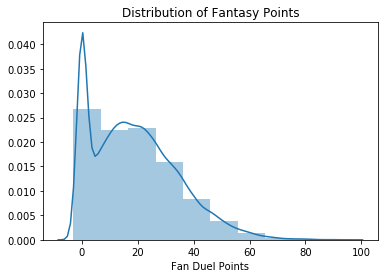

In [3]:
full_df = pd.read_csv(f'../Data/CompleteMerge(2018-2020)[{num_games}].csv').dropna()
col = ['MP', 'FG', 'FGA', '3P', '3PA',
        'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK',
        'PTS', '+-', 'FDP']
x_col = [f'{num_games}_{i}' for i in col] + ['FDS', 'FD_change']
X = np.array(full_df[[i for i in x_col]])
y = np.array(full_df[['FDP']])

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = .8)

sns.distplot(y, bins = 10)
plt.xlabel('Fan Duel Points'); plt.title('Distribution of Fantasy Points')

## Linear Model

Text(0, 0.5, 'Actual')

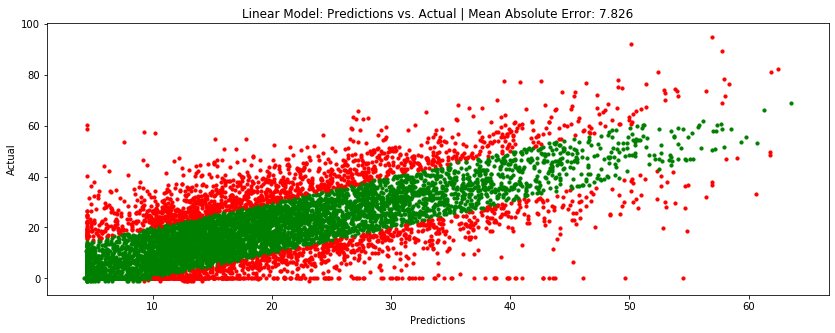

In [4]:
from sklearn.linear_model import LinearRegression 

#initialize object
linear = LinearRegression()

#fit x_train and y_train to model
linear.fit(x_train, y_train)

#make predictions using x_test and y_test
linear_predictions = linear.predict(x_test)

#plot the actual vs predicted
plt.figure(figsize = (14,5))
actual_predict = list(zip(linear_predictions, y_test))
s_diff = 0
for i in actual_predict: 
    predict = i[0][0]
    actual = i[1][0]
    diff = abs(predict - actual)
    if diff <= 10: 
        color = 'green' #good prediction
    else: 
        color = 'red'   #bad prediction
    plt.scatter(predict, actual, s=10, c = color)
    s_diff += diff
linear_loss = round(s_diff/len(actual_predict),3)
plt.title(f'Linear Model: Predictions vs. Actual | Mean Absolute Error: {linear_loss}')
plt.xlabel('Predictions'); plt.ylabel('Actual')

Text(0.5, 1.0, 'Bar Plot Showing the Coefficients for Each Column')

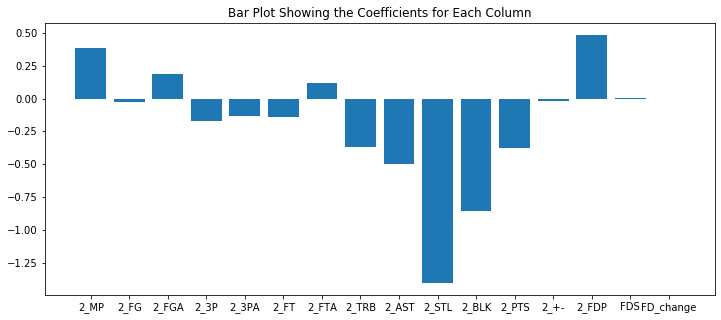

In [5]:
input_variables = full_df[[i for i in x_col]].columns.to_list()

coeff = linear.coef_[0]
plt.figure(figsize = (12,5))
plt.bar(input_variables, coeff)
plt.title('Bar Plot Showing the Coefficients for Each Column')

# Neural Networks

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = .8)
min_max = MinMaxScaler()
x_train = min_max.fit_transform(x_train)
x_test = min_max.fit_transform(x_test)

epochs = 50 
batches = 2 

### Sequential AAN

In [7]:
def sequential_AAN(x,y, metrics = ['accuracy']): 
    drop = .2

    model = Sequential()
    
    model.add(Dense(x.shape[1],input_dim = x.shape[1], activation = 'relu'))
    model.add(Dropout(drop)) #regularization

    
    model.add(Dense(256 , activation = 'relu'))
    model.add(Dropout(drop))

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(drop)) 

    
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mae', optimizer = 'adam', metrics = metrics)
    return model

In [8]:
seq_ann = sequential_AAN(x_train, y_train)
aan_history = seq_ann.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_data= (x_test,y_test))

Epoch 1/50
17916/17916 [==============================] - 16s 878us/step - loss: 8.1263 - accuracy: 0.0651 - val_loss: 8.1211 - val_accuracy: 0.1055
Epoch 2/50
17916/17916 [==============================] - 16s 914us/step - loss: 7.7731 - accuracy: 0.0920 - val_loss: 7.3977 - val_accuracy: 0.0887
Epoch 3/50
17916/17916 [==============================] - 16s 906us/step - loss: 7.7432 - accuracy: 0.1008 - val_loss: 8.2181 - val_accuracy: 0.1124
Epoch 4/50
17916/17916 [==============================] - 15s 864us/step - loss: 7.6996 - accuracy: 0.1030 - val_loss: 7.7177 - val_accuracy: 0.0988
Epoch 5/50
17916/17916 [==============================] - 16s 902us/step - loss: 7.6669 - accuracy: 0.1031 - val_loss: 7.7370 - val_accuracy: 0.1055
Epoch 6/50
17916/17916 [==============================] - 15s 845us/step - loss: 7.6573 - accuracy: 0.1044 - val_loss: 7.7785 - val_accuracy: 0.1111
Epoch 7/50
17916/17916 [==============================] - 15s 848us/step - loss: 7.6520 - accuracy: 0.1046

In [9]:
seq_ann.save('AAN_Model_Weights.h5')

In [10]:
def multivar_RNN(x,y, metrics = ['accuracy']): 
    model = Sequential()
    units = 128
    drop = .2
    
    #input
    model.add(LSTM(units, return_sequences = True, input_shape = (1,x.shape[2])))
    model.add(Dropout(drop))
    
    #1st hidden
    model.add(LSTM(units = units, return_sequences = True, input_shape = (1,x.shape[2])))
    model.add(Dropout(drop))
    
    #2nd hidden
    model.add(LSTM(units = units, return_sequences = True, input_shape = (1,x.shape[2])))
    model.add(Dropout(drop))
    
    #3rd hidden
    model.add(LSTM(units, return_sequences = False, input_shape = (1,x.shape[2])))
    model.add(Dropout(drop))
    
    #output layer
    model.add(Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mae', metrics = metrics)
    
    return model
        

In [11]:
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_train = x_train.reshape((x_train.shape[0],1, x_train.shape[1]))
mult_rnn = multivar_RNN(x_train, y_train)
rnn_history = mult_rnn.fit(x_train, y_train, epochs = epochs, batch_size = batches, validation_data= (x_test,y_test))

Epoch 1/50
17916/17916 [==============================] - 84s 5ms/step - loss: 7.9174 - accuracy: 0.0481 - val_loss: 7.4049 - val_accuracy: 0.0865
Epoch 2/50
17916/17916 [==============================] - 82s 5ms/step - loss: 7.6354 - accuracy: 0.0914 - val_loss: 7.3936 - val_accuracy: 0.0740
Epoch 3/50
17916/17916 [==============================] - 82s 5ms/step - loss: 7.5777 - accuracy: 0.1028 - val_loss: 7.8579 - val_accuracy: 0.1148
Epoch 4/50
17916/17916 [==============================] - 82s 5ms/step - loss: 7.5496 - accuracy: 0.1057 - val_loss: 7.3919 - val_accuracy: 0.0827
Epoch 5/50
17916/17916 [==============================] - 83s 5ms/step - loss: 7.5282 - accuracy: 0.1081 - val_loss: 7.4951 - val_accuracy: 0.0932
Epoch 6/50
17916/17916 [==============================] - 83s 5ms/step - loss: 7.5102 - accuracy: 0.1124 - val_loss: 7.3956 - val_accuracy: 0.1177
Epoch 7/50
17916/17916 [==============================] - 84s 5ms/step - loss: 7.4977 - accuracy: 0.1124 - val_loss: 7

In [12]:
mult_rnn.save('RNN_Model_weights.h5')